Universidad Galileo

Statistical Learning I

PAPD - Sección V

Sergio José Barrios Martínez

Carnet No. 19012765

# Práctica No. 2
## Parte 1: Regresión Polinomial & Feature Engineering

Modelo exponencial de covid-19 usando feature-eng


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import tensorflow as tf
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")

Enabled compatitility to tf1.x


In [15]:
covid19_data = pd.read_csv('covid_19_clean_complete.csv')
covid19_data["Date"] = pd.to_datetime(covid19_data["Date"],infer_datetime_format = True)

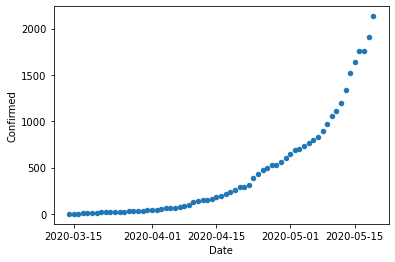

In [16]:
GT_confirmed = covid19_data[(covid19_data["Country/Region"] == 'Guatemala') & (covid19_data["Confirmed"] > 0)].copy()
GT_confirmed.plot.scatter(x = "Date",y="Confirmed")

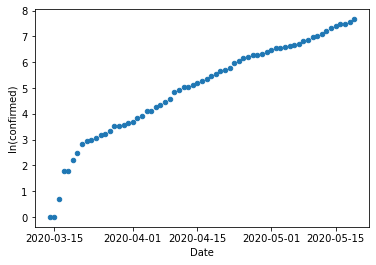

In [17]:
GT_confirmed["ln(confirmed)"] = np.log(GT_confirmed["Confirmed"])
GT_confirmed.plot.scatter(x = "Date",y="ln(confirmed)")

In [18]:
GT_confirmed.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,ln(confirmed)
13903,NaN,Guatemala,15.7835,-90.2308,2020-03-14,1,0,0,0.000000
14168,NaN,Guatemala,15.7835,-90.2308,2020-03-15,1,0,0,0.000000
14433,NaN,Guatemala,15.7835,-90.2308,2020-03-16,2,1,0,0.693147
14698,NaN,Guatemala,15.7835,-90.2308,2020-03-17,6,1,0,1.791759
14963,NaN,Guatemala,15.7835,-90.2308,2020-03-18,6,1,0,1.791759


### Selección del Conjunto de Datos

En este proceso se agregará una columna con el número de día, que se obtendrá a partir de un día inicial y la fecha contenida en el dataset original. Para ello, se implementará una función que recibe:
- La fecha para el día inicial
- DataFrame con los Datos

La función retornará el nuevo conjunto de datos y un scatter plot de la transformación logarítmica (logaritmo natural), para facilitar la selección del día inicial.


Posteriormente, se crea una función que permita elegir el día inicial, a partir del cual se desea hacer la regresión. 

In [19]:
def dia_inicial(Fecha,DataFrame):        
    dia = DataFrame["Date"]
    numero_dia = (pd.to_datetime(dia) - pd.to_datetime(Fecha)).dt.days
    DataFrame['dia']=numero_dia
    DataFrame = DataFrame[(DataFrame["dia"] >= 0)].copy()
    
    DataFrame["ln(confirmed)"] = np.log(DataFrame["Confirmed"])
    DataFrame.plot.scatter(x="dia",y="ln(confirmed)")
    
    return (DataFrame)

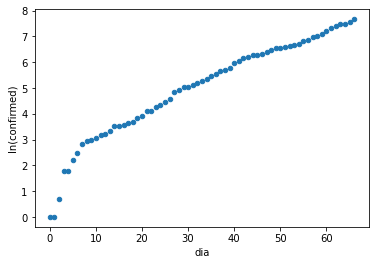

In [20]:
Datos_COVID = dia_inicial('2020-03-14',GT_confirmed)

Se verifica el resultado de la transformación con logaritmo natural. Se comprueba que para fechas menores al 22 de Marzo (día 8), los datos son atípicos, ya que los puntos tienen un comportamiento no lineal. Por lo cual se cambiará la selección para empezar el 22 de Marzo.

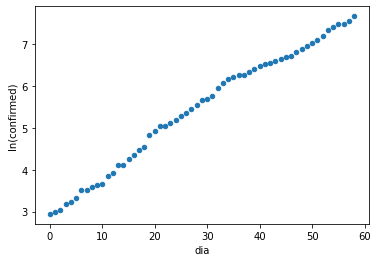

In [21]:
Datos_COVID = dia_inicial('2020-03-22',GT_confirmed)

Se entrenará entonces un modelo lineal, utilizando "día" como variable independiente y "Confirmed" como independiente.

Se utilizará para esto TensorFlow y Regresión Lineal simple.

#### Definición del Grafo

In [40]:
grafo_COVID = tf.Graph()

with grafo_COVID.as_default():
    
    # Placeholders
    learning_rate_COVID = tf.placeholder(tf.float32,name="lr") # Hiper-parámetro de Tasa de Aprendizaje
    tensor_x_COVID = tf.placeholder(tf.float32,[59,2],"tensor_x") # Placeholder de Matriz de Features.
    tensor_y_COVID = tf.placeholder(tf.float32,[59,1],"tensor_y") # Placeholder de Calidad en el grafo.

    # Variables 
    W_COVID = tf.get_variable(name="W",dtype=tf.float32,shape=[2,1],initializer=tf.zeros_initializer())

    # Cálculo vectorizado del Modelo Y = x*W
    with tf.name_scope("modelo_lineal"):
        prediccion_COVID = tf.matmul(tensor_x_COVID,W_COVID) # Hipótesis del modelo

    with tf.name_scope("error_modelo"):
        # Cálculo vectorizado del Error de la Hipótesis (MSE)
        error_COVID = tf.reduce_mean(tf.math.square(tf.math.subtract(tensor_y_COVID,prediccion_COVID))) / 2
        error_summary_COVID = tf.summary.scalar("error",error_COVID)

    with tf.name_scope("gradiente_error"):
        # Gradiente sobre el error (m1,b)
        gradiente_COVID = tf.gradients(error_COVID,[W_COVID]) # Se usa la auto-diferenciación de TensorFlow

    with tf.name_scope("actualizacion_parametros"):
        # Actualización de parámetros
        actualizacion_m_COVID = tf.assign(W_COVID[0], W_COVID[0] - learning_rate_COVID*gradiente_COVID[0][0]) # Intercepto
        actualizacion_b_COVID = tf.assign(W_COVID[1], W_COVID[1] - learning_rate_COVID*gradiente_COVID[0][1]) # Pendiente
        actualizacion_parametros_COVID = tf.group(actualizacion_b_COVID,actualizacion_m_COVID)
    
    init = tf.global_variables_initializer()

### Grafo

<img src="./Imagenes_t2/Grafo.png">


### Despliegue de Grafo

<img src="./Imagenes_t2/Grafo_Desplegado.png">

### Ejecución

In [66]:
# Función de Entrenamiento con Batch Gradient Descent (parámetros Learning Rate y Número de Iteraciones)
def entrenamiento_COVID(lr_COVID,iteraciones_COVID):
    
    now = datetime.datetime.now()
    
    tf.reset_default_graph()
    with tf.Session(graph=grafo_COVID) as session:

        # String de Configuración ("Año""Mes""Dia"-"Hora""Minuto""Segundo"-"lr=""valor Learning Rate"-"it=""iteracion")
        writer = tf.summary.FileWriter('./graphs_COVID/'+now.strftime("%Y%m%d-%H%M%S")+'-lr=' \
                                       +str(lr_COVID)+'-it='+str(iteraciones_COVID), 
                                       session.graph)
 
        session.run(init) # Inicialización de Variables

        # Preparación de Matriz X para cálculo vectorizado en la forma Y=X*W para (Y=mX+b)
        unos = np.ones((np.size(X_COVID), 1)) 
        matriz_x_COVID = np.concatenate((X_COVID,unos),axis=1)

        feed_dict = {tensor_x_COVID:matriz_x_COVID,tensor_y_COVID:Y_trans_COVID,learning_rate_COVID:lr_COVID}
        predicciones_COVID = session.run(prediccion_COVID,feed_dict=feed_dict)

        for i in range(iteraciones_COVID):

            if (i+1) % 10 == 0 or i == 0:

                MSE_summary_COVID = session.run(error_summary_COVID,feed_dict=feed_dict)
                writer.add_summary(MSE_summary_COVID, i) # Escalar del MSE

         
            # Gradient Descent
            session.run(actualizacion_parametros_COVID,feed_dict=feed_dict)
            predicciones_COVID = session.run(prediccion_COVID,feed_dict=feed_dict)
        
        print("Coeficientes Modelo Lineal:")
        print("intercepto: ",session.run([W_COVID][0][1][0]))
        print("pendiente: ",session.run([W_COVID][0][0][0]))
        writer.close()

In [95]:
# Entrenamiento del Modelo (sobre datos transformados por ln)

# X,Y,Y_transformada
X_COVID = np.expand_dims(np.array(Datos_COVID["dia"].values),1)
Y_COVID = np.expand_dims(np.array(Datos_COVID["Confirmed"].values),1)
Y_trans_COVID = np.expand_dims(np.array(Datos_COVID["ln(confirmed)"].values),1)

#### Primer Experimento (Learning Rate: 0.0001, iteraciones: 1000)

In [96]:
entrenamiento_COVID(0.0001,1000)

Coeficientes Modelo Lineal:
intercepto:  0.08157749
pendiente:  0.15892911


<img src="./Imagenes_t2/PrimerExperimento_COVID.png">

El MSE empieza a converger, por lo que se incrementara el learning rate y se verificará la tendencia.

#### Segundo Experimento (Learning Rate: 0.001, iteraciones: 1000)

In [99]:
entrenamiento_COVID(0.001,1000)

Coeficientes Modelo Lineal:
intercepto:  0.69622135
pendiente:  0.14316545


<img src="./Imagenes_t2/SegundoExperimento_COVID.png">

El MSE sigue decrementando, por lo que se incrementara nuevamente el learning rate y se verificará la tendencia.

#### Segundo Experimento (Learning Rate: 0.01, iteraciones: 1000)

In [100]:
entrenamiento_COVID(0.01,1000)

Coeficientes Modelo Lineal:
intercepto:  nan
pendiente:  nan


El MSE empezó a divergir, por lo que se decrementará el learning rate a un valor intermedio, se incrementarán las iteraciones y se verificará la tendencia.

#### Tercer Experimento (Learning Rate: 0.0016, iteraciones: 10000)

In [103]:
entrenamiento_COVID(0.0016,10000)

Coeficientes Modelo Lineal:
intercepto:  3.0148365
pendiente:  0.083700314


<img src="./Imagenes_t2/TercerExperimento_COVID.png">

Este MSE es bastante aceptable, por lo tanto, procedemos a formular el modelo. Se considerará también que hay que transformar de vuelta el resultado obtenido, utilizando la **función exponencial**:

In [104]:
def modelo_COVID(valores_X):
    return np.exp((0.083700314 * valores_X + 3.0148365))    

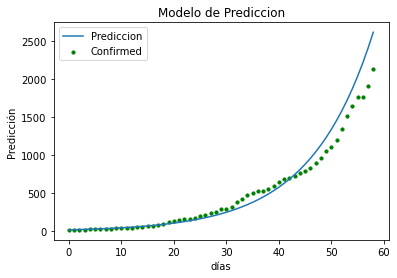

In [106]:
# Obtención del Valores de Predicción
Modelo_lineal_Confirmed = modelo_COVID(X_COVID)

plt.scatter(X_COVID,Y_COVID,c='green',s=10,label='Confirmed')
plt.plot(X_COVID,Modelo_lineal_Confirmed,label='Prediccion')
plt.legend(loc = 'best')
plt.title('Modelo de Prediccion')
plt.xlabel('días')
plt.ylabel('Predicción')
plt.show()

Finalmente, ya teniendo el modelo, se realiza la función para predecir una cantidad de casos confirmados para una fecha específica:

In [107]:
def prediccion_COVID(fecha_prediccion,DataFrame,modelo):
    
    from datetime import datetime
    
    # Obtención del Número de Día a Predecir
    dia_inicial = str(DataFrame["Date"][DataFrame["dia"] == 0].iloc[0])
    dia_inicial = dia_inicial[:10]
    dia_inicial = datetime.strptime(dia_inicial, "%Y-%m-%d")
    dia_prediccion = abs(datetime.strptime(fecha_prediccion, "%Y-%m-%d") - dia_inicial).days
    
    # Obtención del número de casos del día a predecir
    prediccion = modelo_COVID(dia_prediccion)
    print("Predicción de casos COVID-19 para el",fecha_prediccion,":",np.around(prediccion,2))
    return(prediccion)


### Predicción de Casos de COVID-19 para una fecha específica:

In [109]:
prediccion_COVID('2020-06-06',Datos_COVID,modelo_COVID)

Predicción de casos COVID-19 para el 2020-06-06 : 11802.43


11802.425781151082

## Parte 2 - Modelo polinomial para Calidad de Vino

In [110]:
datos_vino = pd.read_csv('winequality-red.csv')
datos_vino.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [111]:
fixed_acidity = datos_vino["fixed acidity"].values
volatile_acidity = datos_vino["volatile acidity"].values
citric_acid = datos_vino["citric acid"].values
residual_sugar = datos_vino["residual sugar"].values
chlorides = datos_vino["chlorides"].values
free_sulfur_dioxide = datos_vino["free sulfur dioxide"].values
total_sulfur_dioxide = datos_vino["total sulfur dioxide"].values
density = datos_vino["density"].values
pH = datos_vino["pH"].values
sulphates = datos_vino["sulphates"].values
alcohol = datos_vino["alcohol"].values
calidad = datos_vino["quality"].values

In [112]:
datos_vino.corr()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.124052
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.390558
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.226373
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.013732
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.128907
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.050656
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654,-0.185100
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180,-0.174919
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633,-0.057731
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595,0.251397


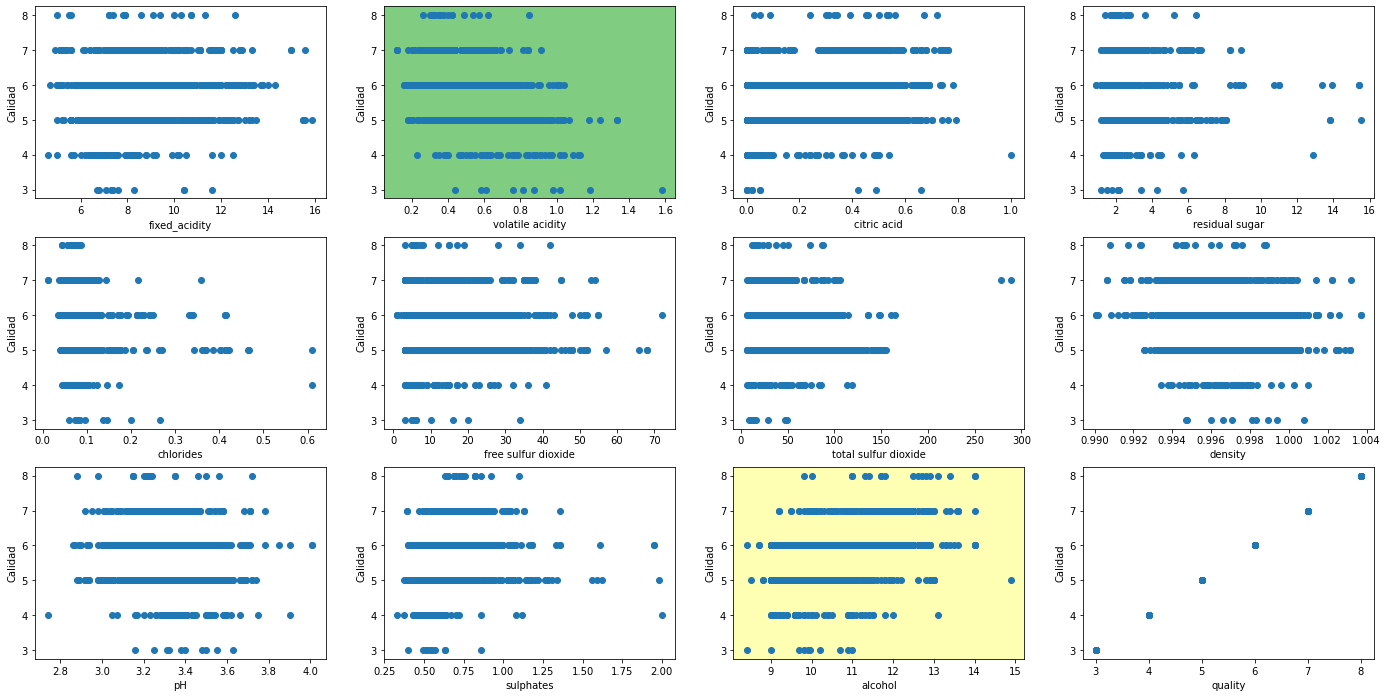

In [113]:
fig, ax = plt.subplots(3, 4, figsize=(24, 12))
                      
# Matriz de Figuras
ax[0, 0].scatter(fixed_acidity, calidad)
ax[0, 0].set(xlabel='fixed_acidity', ylabel='Calidad')

ax[0, 1].scatter(volatile_acidity, calidad)
ax[0, 1].set(xlabel='volatile acidity', ylabel='Calidad')
ax[0, 1].set_facecolor((0.5, 0.8, 0.5))

ax[0, 2].scatter(citric_acid, calidad)
ax[0, 2].set(xlabel='citric acid', ylabel='Calidad')

ax[0, 3].scatter(residual_sugar, calidad)
ax[0, 3].set(xlabel='residual sugar', ylabel='Calidad')

ax[1, 0].scatter(chlorides, calidad)
ax[1, 0].set(xlabel='chlorides', ylabel='Calidad')

ax[1, 1].scatter(free_sulfur_dioxide, calidad)
ax[1, 1].set(xlabel='free sulfur dioxide', ylabel='Calidad')

ax[1, 2].scatter(total_sulfur_dioxide, calidad)
ax[1, 2].set(xlabel='total sulfur dioxide', ylabel='Calidad')

ax[1, 3].scatter(density, calidad)
ax[1, 3].set(xlabel='density', ylabel='Calidad')

ax[2, 0].scatter(pH, calidad)
ax[2, 0].set(xlabel='pH', ylabel='Calidad')

ax[2, 1].scatter(sulphates, calidad)
ax[2, 1].set(xlabel='sulphates', ylabel='Calidad')

ax[2, 2].scatter(alcohol, calidad)
ax[2, 2].set(xlabel='alcohol', ylabel='Calidad')
ax[2, 2].set_facecolor((1, 1, 0.7))

ax[2, 3].scatter(calidad, calidad)
ax[2, 3].set(xlabel='quality', ylabel='Calidad')

plt.show()

Con base en este análisis exploratorio en la matriz de correlación y los scatter plots, las correlaciones más grandes entre la calidad del vino y sus características ocurre con **volatile acidity** y con **alcohol**. 

El coeficiente de correlación entre la calidad del vino y su acidez volátil es de **-0.390558**, y con el contenido de alcohol es de **0.476166**. Por lo tanto se trabajará el modelo con estas dos características.

#### Modelo Polinomial con Scikit-Learn

Inicialmente se formará la "matriz X" que contendrá como columnas las características mencionadas con anterioridad:

In [114]:
matriz_X = np.matrix([volatile_acidity,alcohol]).T

Se encuentra la matriz de caracterísiticas polinomiales y de interacción.
Se seleccionará para esta práctica, un polinomio de grado 2.

In [115]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)
matriz_X_transformada = poly.fit_transform(matriz_X)

data_frame_features=pd.DataFrame(matriz_X_transformada)
data_frame_features.columns= ['intercepto','volatile acidity','alcohol',
                     '(volatile acidity)^2','(volatile acidity * alcohol)','(alcohol)^2']

data_frame_features


,intercepto,volatile acidity,alcohol,(volatile acidity)^2,(volatile acidity * alcohol),(alcohol)^2
0,1.0,0.700,9.4,0.490000,6.580,88.36
1,1.0,0.880,9.8,0.774400,8.624,96.04
2,1.0,0.760,9.8,0.577600,7.448,96.04
3,1.0,0.280,9.8,0.078400,2.744,96.04
4,1.0,0.700,9.4,0.490000,6.580,88.36
...,...,...,...,...,...,...
1594,1.0,0.600,10.5,0.360000,6.300,110.25
1595,1.0,0.550,11.2,0.302500,6.160,125.44
1596,1.0,0.510,11.0,0.260100,5.610,121.00
1597,1.0,0.645,10.2,0.416025,6.579,104.04


### TensorFlow

Se definirá el grafo para calcular regresión polinomial utilizando el feature engineering resumido en la matriz anterior.

### Definición del Grafo

In [116]:
grafo = tf.Graph()

with grafo.as_default():
    
    # Placeholders
    learning_rate = tf.placeholder(tf.float32,name="lr") # Hiper-parámetro de Tasa de Aprendizaje
    tensor_x = tf.placeholder(tf.float32,[1599,6],"tensor_x") # Placeholder de Matriz de Features.
    tensor_y = tf.placeholder(tf.float32,[1599,1],"tensor_y") # Placeholder de Calidad en el grafo.

    # Variables 
    W = tf.get_variable(name="W",dtype=tf.float32,shape=[6,1],initializer=tf.zeros_initializer())

    # Cálculo vectorizado del Modelo Y = x*W
    with tf.name_scope("modelo_lineal"):
        prediccion = tf.matmul(tensor_x,W) # Hipótesis del modelo

    with tf.name_scope("error_modelo"):
        # Cálculo vectorizado del Error de la Hipótesis (MSE)
        error = tf.reduce_mean(tf.math.square(tf.math.subtract(tensor_y,prediccion))) / 2
        error_summary = tf.summary.scalar("error",error)

    with tf.name_scope("gradiente_error"):
        # Gradiente sobre el error (b,m1,m2,m3,m4,m5)
        gradiente = tf.gradients(error,[W]) # Se usa la auto-diferenciación de TensorFlow

    with tf.name_scope("actualizacion_parametros"):
        # Actualización de parámetros
        actualizacion_b = tf.assign(W[0], W[0] - learning_rate*gradiente[0][0]) # Intercepto
        actualizacion_m1 = tf.assign(W[1], W[1] - learning_rate*gradiente[0][1]) # volatile acidity
        actualizacion_m2 = tf.assign(W[2], W[2] - learning_rate*gradiente[0][2]) # alcohol
        actualizacion_m3 = tf.assign(W[3], W[3] - learning_rate*gradiente[0][3]) # (volatile acidity)^2	
        actualizacion_m4 = tf.assign(W[4], W[4] - learning_rate*gradiente[0][4]) # (volatile acidity * alcohol)      
        actualizacion_m5 = tf.assign(W[5], W[5] - learning_rate*gradiente[0][5]) # (alcohol)^2
        actualizacion_parametros = tf.group(actualizacion_b,actualizacion_m1,actualizacion_m2,
                                           actualizacion_m3,actualizacion_m4,actualizacion_m5)
    
    init = tf.global_variables_initializer()

#### Grafo

<img src="./Imagenes_t2/Grafo_Vinos.png">


#### Grafo Desplegado

<img src="./Imagenes_t2/Grafo_Vinos_Desplegado.png">

### Ejecución

In [118]:
# Función de Entrenamiento con Batch Gradient Descent (parámetros Learning Rate y Número de Iteraciones)
def entrenamiento(lr,iteraciones):
    
    now = datetime.datetime.now()
    
    tf.reset_default_graph()
    with tf.Session(graph=grafo) as session:

        # String de Configuración 
        #("Año""Mes""Dia"-"Hora""Minuto""Segundo"-"lr=""valor Learning Rate"-"pol_grad=""grado polinomio"-"it=""iteracion")
        writer = tf.summary.FileWriter('./graphs_t2/'+now.strftime("%Y%m%d-%H%M%S")+'-lr='+str(lr) \
                                       +'-pol_grad=2'+'-it='+str(iteraciones), session.graph)
 
        session.run(init) # Inicialización de Variables

        feed_dict = {tensor_x:matriz_X_transformada,tensor_y:np.expand_dims(calidad,axis=1),learning_rate:lr}
        predicciones = session.run(prediccion,feed_dict=feed_dict)

        for i in range(iteraciones):

            if (i+1) % 1 == 0 or i == 0:

                MSE_summary = session.run(error_summary,feed_dict=feed_dict)
                writer.add_summary(MSE_summary, i) # Escalar del MSE
         
            # Gradient Descent
            session.run(actualizacion_parametros,feed_dict=feed_dict)
            predicciones = session.run(prediccion,feed_dict=feed_dict)
            
        print("Matriz de coeficientes:")
        print("intercepto: ",session.run([W])[0][0])
        print("volatile acidity: ",session.run([W])[0][1])
        print("alcohol:",session.run([W])[0][2])
        print("(volatile acidity)^2: ",session.run([W])[0][3])
        print("(volatile acidity * alcohol):",session.run([W])[0][4])
        print("(alcohol)^2:",session.run([W])[0][5])
        
  
        writer.close()

#### Primer Experimento
Se iniciará con un Learning Rate: 0.00001 e iteraciones: 100

In [119]:
entrenamiento(0.00001,100)

Matriz de coeficientes:
intercepto:  [0.00059163]
volatile acidity:  [0.0002934]
alcohol: [0.00544934]
(volatile acidity)^2:  [0.00015554]
(volatile acidity * alcohol): [0.00267535]
(alcohol)^2: [0.04921415]


<img src="./Imagenes_t2/PrimerExperimento_Vinos.png">


#### Segundo Experimento
Se observa convergencia del MSE. Se incrementará el Learning Rate: 0.0001 manteniendo las iteraciones: 100

In [120]:
entrenamiento(0.0001,100)

Matriz de coeficientes:
intercepto:  [0.00203343]
volatile acidity:  [0.00090692]
alcohol: [0.01321832]
(volatile acidity)^2:  [0.00036974]
(volatile acidity * alcohol): [0.00537622]
(alcohol)^2: [0.04834742]


<img src="./Imagenes_t2/SegundoExperimento_Vinos.png">


#### Tercer Experimento
No se observa cambio significativo en el MSE. Se incrementará el Learning Rate: 0.001 manteniendo las iteraciones: 100

In [121]:
entrenamiento(0.001,100)

Matriz de coeficientes:
intercepto:  [nan]
volatile acidity:  [nan]
alcohol: [nan]
(volatile acidity)^2:  [nan]
(volatile acidity * alcohol): [nan]
(alcohol)^2: [nan]


#### Cuarto Experimento
Aquí se encuentra ya divergencia del MSE. Por lo tanto, se decrementará el Learning Rate al valor anterior: 0.0001 subiendo las iteraciones: 1000

In [125]:
entrenamiento(0.00010,1000)

Matriz de coeficientes:
intercepto:  [0.01536227]
volatile acidity:  [0.00593119]
alcohol: [0.08505818]
(volatile acidity)^2:  [0.00157797]
(volatile acidity * alcohol): [0.02349982]
(alcohol)^2: [0.04066562]


<img src="./Imagenes_t2/CuartoExperimento_Vinos.png">


#### Quinto Experimento
El MSE sigue decrementando. Se mantendrá el Learning Rate: 0.001 subiendo las iteraciones: 10000

In [126]:
entrenamiento(0.00010,10000)

Matriz de coeficientes:
intercepto:  [0.09176505]
volatile acidity:  [0.01935531]
alcohol: [0.49740353]
(volatile acidity)^2:  [-0.01002178]
(volatile acidity * alcohol): [-0.03507382]
(alcohol)^2: [0.00448725]


<img src="./Imagenes_t2/QuintoExperimento_Vinos.png">


#### Sexto Experimento
Se observa convergencia. Se mantendrá el Learning Rate: 0.001 subiendo las iteraciones: 50000

In [127]:
entrenamiento(0.00010,50000)

Matriz de coeficientes:
intercepto:  [0.14576715]
volatile acidity:  [0.0237781]
alcohol: [0.7904866]
(volatile acidity)^2:  [-0.02709518]
(volatile acidity * alcohol): [-0.12868886]
(alcohol)^2: [-0.01868645]


<img src="./Imagenes_t2/SextoExperimento_Vinos.png">



Este resultado es más satisfactorio, ya que se observa convergencia del MSE con varias iteraciones.

## Conclusiones
- Las variables **volatile acidity** y **alcohol** con las que mostraron mayor correlación con la variable **quality** del vino. El coeficiente de correlación entre la calidad del vino y su acidez volátil es de **-0.390558**, y con el contenido de alcohol es de **0.476166**. Por este motivo se seleccionaron ambas variables para el modelo polinomial. 

- El modelo entrenado muestra una convergencia del MSE a un valor de aproximadamente **0.2219**, el cual se logró en el Sexto Experimento. Este valor se alcanzó prácticamente en la iteración 45,000. Por tanto se concluye que es un valor aceptable de convergencia, pues el último experimento tuvo 50,000 iteraciones.

- El modelo polinomial de segundo grado, con términos de interacción final es:

- $quality = 0.14576715 + 0.0237781*(volatile\_acidity) + 0.7904866*(alcohol) - 0.02709518*(volatile\_acidity)^2 - 0.12868886*(volatile\_acidity * alcohol) - 0.01868645*(alcohol)^2$